# Evaluation of 1 Model With Physgen

In [1]:
model_1 = "pix2pix_1_0"
model_type = "pix2pix"

data_1 = "../../data/nms1000_test_1_1_2500_2500"
data_1_type = "physgen"

### Env Setup

In [ ]:
!conda create -n eval python=3.8 -y
!conda activate eval

Activate now eval env and run:

In [ ]:
!pip install pandas
!pip install ipython
!pip install ipykernel
!pip install opencv-python
!pip install shapely
!pip install pytorch-msssim
!pip install -r requirements.txt

> Set 'eval' as your python env

### Imports

In [2]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2

In [3]:
!python --version

Python 3.8.20


### Helper

In [3]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cmap=None, cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    ---
    Parameters:
    - img : np.ndarray
        Images/Images with [width, height, channels] or for multiple: [batch_size/images, width, height, channels].
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    original_style = plt.rcParams.copy()

    img_shape = img.shape
    print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        # if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], img.shape[2]))
        # else:
        #     # there could be cases where this is wrong
        #     img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[2], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    print(f"Transformed shape to: {img_shape}")

    # invert images
    if invert:
        print("Invert images...")
        max_value = 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        print(f"Using '{plt_style}' plotting style.")

    # plotting
    print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            used_cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            used_cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            used_cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            if len(cur_img.shape) == 3 and cur_img.shape[2]:
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
            else:
                cur_img = cur_img
            print(cur_img.shape)
            used_cmap = "gray"

        if cmap:
            used_cmap = cmap

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

        cur_ax.imshow(cur_img, cmap=used_cmap)

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

def show_images(image_paths:list, title=None, image_width=5, axis=False,
                color_space="gray", cmap=None, 
                cols=2, save_to=None,
                hspace=0.01, wspace=0.01,
                use_original_sytle=False, invert=False):
    """
    Visulalizes/shows one or multiple images.

    ---
    Parameters:
    - image_paths : List[str]
        List of paths to the images which should get visualized.
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    if color_space.lower() == "rgb":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in image_paths])
    elif color_space.lower() == "hsv":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV) for img in image_paths])
    else:
        images = np.array([cv2.imread(img) for img in image_paths])
    imshow(images, title=title, image_width=image_width, axis=axis,
           color_space=color_space, cmap=cmap, cols=cols, save_to=save_to,
           hspace=hspace, wspace=wspace,
           use_original_sytle=use_original_sytle, invert=invert)
    return images

### Run Tests

In [7]:
!python test.py \
  --dataroot {data_1} \
  --name {model_1} \
  --model {model_type} \
  --batch_size 18 \
  --dataset_mode {data_1_type} \
  --input_nc 1 \
  --output_nc 1 \
  --load_size 256 \
  --netG unet_256 \
  --max_dataset_size 1000 \
  --num_test 1000 \
  --results_dir ./eval/{model_1} \
  --phase test \
  --eval

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 18                            	[default: 1]
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_1_1_2500_2500	[default: None]
             dataset_mode: physgen                       	[default: aligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
                  isTrain: False                         	[de

### Extract Test Predictions

In [8]:
evaluation_path = f"./eval/{model_1}/{model_1}/test_latest/images"
target_path = f"../../data/eval/{model_1}"

In [9]:
!python eval_extractor.py \
    --name {model_1} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied real from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_929_real_B.png' to '../../data/eval/pix2pix_1_0/real/buildings_929.png'
[info] copied pred from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_68_fake_B.png' to '../../data/eval/pix2pix_1_0/pred/buildings_68.png'
[info] copied pred from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_595_fake_B.png' to '../../data/eval/pix2pix_1_0/pred/buildings_595.png'
[info] copied real from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_70_real_B.png' to '../../data/eval/pix2pix_1_0/real/buildings_70.png'
[info] copied osm from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_261_real_A.png' to '../../data/eval/pix2pix_1_0/osm/buildings_261.png'
[info] copied osm from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/buildings_857_real_A.png' to '../../data/eval/pix2pix_1_0/osm/buildings_857.png'
[info] copied osm from './eval/pix2pix_1_0/pix2pix_1_0/test_latest

### Calc Eval metrics

In [10]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_1}/real \
    --pred_dir ../../data/eval/{model_1}/pred \
    --osm_dir ../../data/eval/{model_1}/osm \
    --output ./eval_results/evaluation_{model_1}.csv

Evaluating samples:  10%|██                  | 101/1001 [00:02<00:22, 40.72it/s]Prediction for sample ._real.png not found.
../../data/eval/pix2pix_1_0/pred/._real.png
Evaluating samples: 100%|███████████████████| 1001/1001 [00:26<00:00, 37.82it/s]
               MAE         MAPE  ...    LoS_wMAPE   NLoS_wMAPE
count  1000.000000  1000.000000  ...  1000.000000  1000.000000
mean      4.444653    20.969383  ...    20.969429    17.957598
std       1.704149     6.515928  ...     6.516029    11.217666
min       0.647224     3.963208  ...     3.962795     0.000000
25%       3.345735    17.006152  ...    17.006381     8.108115
50%       4.683018    22.305396  ...    22.305449    17.117111
75%       5.679563    25.402956  ...    25.403112    27.586206
max       9.134192    36.809696  ...    36.810001    43.089428

[8 rows x 6 columns]


### Show Results

In [11]:
mae_model_1_name = f'MAE_{model_1}'
los_mae_model_1_name = f'LoS_MAE_{model_1}'
nlos_mae_model_1_name = f'NLoS_MAE_{model_1}'
mape_model_1_name = f'MAPE_{model_1}'
los_wmape_model_1_name = f'LoS_wMAPE_{model_1}'
nlos_wmape_model_1_name = f'NLoS_wMAPE_{model_1}'

In [12]:
df_1 = pd.read_csv(f"./eval_results/evaluation_{model_1}.csv")
# df_1 = df_1.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_1 = df_1.rename(columns={'MAE': mae_model_1_name, 
                            'LoS_MAE': los_mae_model_1_name,
                            'NLoS_MAE': nlos_mae_model_1_name,
                            'MAPE':mape_model_1_name,
                            'LoS_wMAPE': los_wmape_model_1_name,
                            'NLoS_wMAPE': nlos_wmape_model_1_name
                            }
                   )
df_1["sample_id"] = df_1["sample_id"].str.extract(r'_*(\d+)_*')[0].astype(int)
merged_df = df_1
df_1

,sample_id,MAE_pix2pix_1_0,MAPE_pix2pix_1_0,LoS_MAE_pix2pix_1_0,NLoS_MAE_pix2pix_1_0,LoS_wMAPE_pix2pix_1_0,NLoS_wMAPE_pix2pix_1_0
0,893,2.183454,12.806215,2.183452,2.352943,12.806324,5.660383
1,109,3.831853,20.898878,3.831911,0.000000,20.899197,0.000000
2,788,5.951747,29.029835,5.951814,1.568626,29.030226,3.508770
3,974,7.547307,32.820507,7.547405,1.176472,32.820970,2.479341
4,570,0.862235,4.683415,0.862075,11.372547,4.683053,28.431372
...,...,...,...,...,...,...,...
995,247,2.209526,11.277959,2.209362,12.941177,11.277656,31.132078
996,717,6.082255,27.604225,6.082174,11.372547,27.604265,24.999998
997,366,4.459480,20.418798,4.459386,10.588238,20.418745,23.893810
998,503,5.262337,22.431097,5.262208,13.725489,22.430971,30.701754


Using 'seaborn-v0_8' plotting style.

MAE
    - pix2pix_1_0: 4.44

MAPE
    - pix2pix_1_0: 20.97

LoS MAE
    - pix2pix_1_0: 4.44

NLoS MAE
    - pix2pix_1_0: 7.91

LoS wMAPE
    - pix2pix_1_0: 20.97

NLoS wMAPE
    - pix2pix_1_0: 17.96


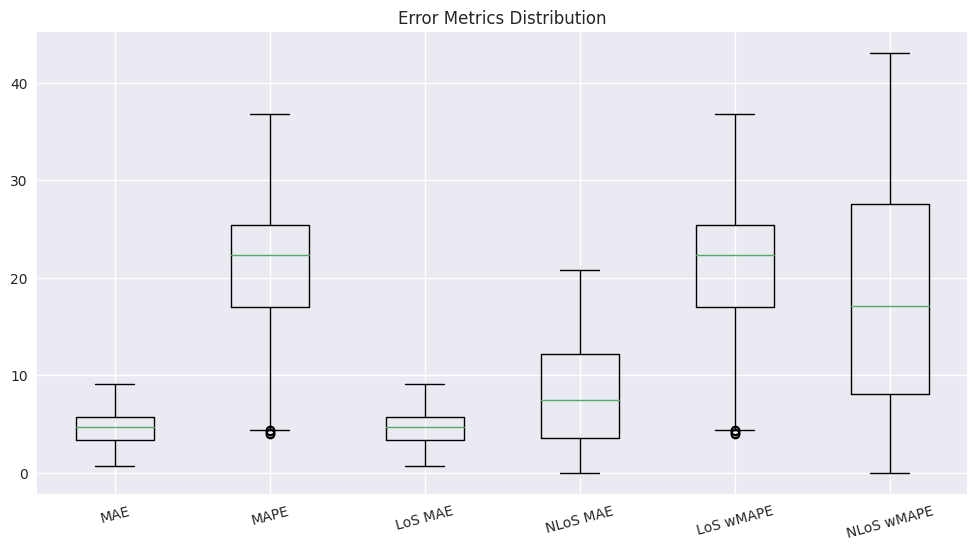

In [13]:
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}' plotting style.")

# fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 16))
# # ax = ax.flatten()

# # MEA
# values = [merged_df[mae_model_1_name]]
# names = [mae_model_1_name]
# ax[0][0].boxplot(x=values, notch=False)
# ax[0][0].set_xticks([1], names)
# ax[0][0].set_xticklabels(names, rotation=15)
# ax[0][0].set_title("Mean Absolut Error")

# # MAPE
# values = [merged_df[mape_model_1_name]]
# names = [mape_model_1_name]
# ax[0][1].boxplot(x=values, notch=False)
# ax[0][1].set_xticks([1], names)
# ax[0][1].set_xticklabels(names, rotation=15)
# ax[0][1].set_title("Mean Absolut Percentage Error")

# # LoS MEA
# values = [merged_df[los_mae_model_1_name]]
# names = [los_mae_model_1_name]
# ax[1][0].boxplot(x=values, notch=False)
# ax[1][0].set_xticks([1], names)
# ax[1][0].set_xticklabels(names, rotation=15)
# ax[1][0].set_title("Line of Sight - Mean Absolut Error")

# # NLoS MEA
# values = [merged_df[nlos_mae_model_1_name]]
# names = [nlos_mae_model_1_name]
# ax[1][1].boxplot(x=values, notch=False)
# ax[1][1].set_xticks([1], names)
# ax[1][1].set_xticklabels(names, rotation=15)
# ax[1][1].set_title("None Line of Sight - Mean Absolut Error")

# # LoS wMAPE
# values = [merged_df[los_wmape_model_1_name]]
# names = [los_wmape_model_1_name]
# ax[2][0].boxplot(x=values, notch=False)
# ax[2][0].set_xticks([1], names)
# ax[2][0].set_xticklabels(names, rotation=15)
# ax[2][0].set_title("Line of Sight - weighted MAPE")

# # NLoS wMAPE
# values = [merged_df[nlos_wmape_model_1_name]]
# names = [nlos_wmape_model_1_name]
# ax[2][1].boxplot(x=values, notch=False)
# ax[2][1].set_xticks([1], names)
# ax[2][1].set_xticklabels(names, rotation=15)
# ax[2][1].set_title("None Line of Sight - weighted MAPE")

# plt.subplots_adjust(hspace=0.9)

values = [
    merged_df[mae_model_1_name],
    merged_df[mape_model_1_name],
    merged_df[los_mae_model_1_name],
    merged_df[nlos_mae_model_1_name],
    merged_df[los_wmape_model_1_name],
    merged_df[nlos_wmape_model_1_name]
]

labels = [
    "MAE",
    "MAPE",
    "LoS MAE",
    "NLoS MAE",
    "LoS wMAPE",
    "NLoS wMAPE"
]

fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(values, notch=False)
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=15)
ax.set_title("Error Metrics Distribution")



print(f"\nMAE\n    - {model_1}: {merged_df[mae_model_1_name].mean():>0.2f}")
print(f"\nMAPE\n    - {model_1}: {merged_df[mape_model_1_name].mean():>0.2f}")
print(f"\nLoS MAE\n    - {model_1}: {merged_df[los_mae_model_1_name].mean():>0.2f}")
print(f"\nNLoS MAE\n    - {model_1}: {merged_df[nlos_mae_model_1_name].mean():>0.2f}")
print(f"\nLoS wMAPE\n    - {model_1}: {merged_df[los_wmape_model_1_name].mean():>0.2f}")
print(f"\nNLoS wMAPE\n    - {model_1}: {merged_df[nlos_wmape_model_1_name].mean():>0.2f}")

Example Image

In [ ]:
if len(cur_id) > 1:
     43     raise ValueError("Too many ids found!")
---> 44 cur_id = cur_id[0]
     45 if cur_id == target_id:
     46     real_image_samples += [cur_image]

In [20]:
def get_same_pred_real_samples(pred_path:str, real_path:str, n_samples:int, ids=None):
    if not ids:
        # choose n random samples
        samples = random.sample(os.listdir(pred_path), n_samples)
        result_samples = [os.path.join(pred_path, cur_image) for cur_image in samples]

        # get the used id's
        ids = []
        for cur_image in samples:
            cur_id = re.findall(r'\d+', string=cur_image)
            if len(cur_id) > 1:
                raise ValueError("Too many ids found!")
            cur_id = cur_id[0]
            if len(cur_id) <= 0:
                raise ValueError(f"One image has no ID: {cur_image}")
            ids += [cur_id]
    else:
        # get pred image
        pred_image_samples = []
        for target_id in ids:
            found = False
            for cur_image in os.listdir(real_path):
                cur_id = re.findall('\d+', string=cur_image)
                if len(cur_id) > 1:
                    raise ValueError(f"Too many ids found in {cur_image}!")
                elif len(cur_id) <= 0:
                    continue
                    # raise ValueError(f"No id found in {cur_image}!")
                cur_id = cur_id[0]
                if cur_id == target_id:
                    pred_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found pred image with id: {target_id}")
        result_samples = [os.path.join(pred_path, cur_image) for cur_image in pred_image_samples]

    # get real image
    real_image_samples = []
    for target_id in ids:
        found = False
        for cur_image in os.listdir(real_path):
            cur_id = re.findall('\d+', string=cur_image)
            if len(cur_id) > 1:
                raise ValueError(f"Too many ids found in {cur_image}!")
            elif len(cur_id) <= 0:
                continue
                # raise ValueError(f"No id found in {cur_image}!")
            cur_id = cur_id[0]
            if cur_id == target_id:
                real_image_samples += [cur_image]
                found = True
                break

        if not found:
            raise ValueError(f"Does not found real image with id: {target_id}")

    result_samples += [os.path.join(real_path, cur_image) for cur_image in real_image_samples]

    return result_samples, ids

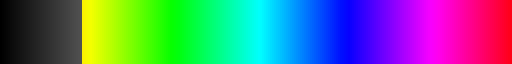

In [15]:
from matplotlib.colors import ListedColormap

def get_unique_hsv_cmap():
    unique_hsv_map = plt.get_cmap("hsv")(np.linspace(0, 1, 256))    # np.arange(0, 256)
    hsv_map = plt.get_cmap("hsv")
    for cur_idx in range(256):
        r, g, b, a = hsv_map(cur_idx)
        if int(r) > 0.99 and int(g) < (90/255):
            gray_value = cur_idx*2 / 255.0
            unique_hsv_map[cur_idx] = (gray_value, gray_value, gray_value, 1.0)
        else:
            break
    unique_hsv = ListedColormap(unique_hsv_map)
    plt.colormaps.register(name="unique_hsv", cmap=unique_hsv, force=True)
    return unique_hsv

# for i in range(256):
#     print([int(cur_color*255) for cur_color in get_cmap('hsv')(i)])

get_unique_hsv_cmap()
plt.get_cmap("unique_hsv")

In [16]:
def plot(ax, path, title="", invert=True, sub_image=None, cmap="unique_hsv", scale=False):
    img = np.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

    if sub_image:
        img_2 = np.array(cv2.imread(sub_image, cv2.IMREAD_GRAYSCALE))
        img = cv2.subtract(img, img_2)
    
    # scaling
    if scale:
        mask = (img > 0) & (img < 160)
        img[mask] = np.clip(img[mask] + 40, 0, 255) # cv2.add(img[mask], 30)

    # invert
    if invert:
        max_value = 255 # 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    ax.axis("off")
    color_ax = ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    
    return color_ax

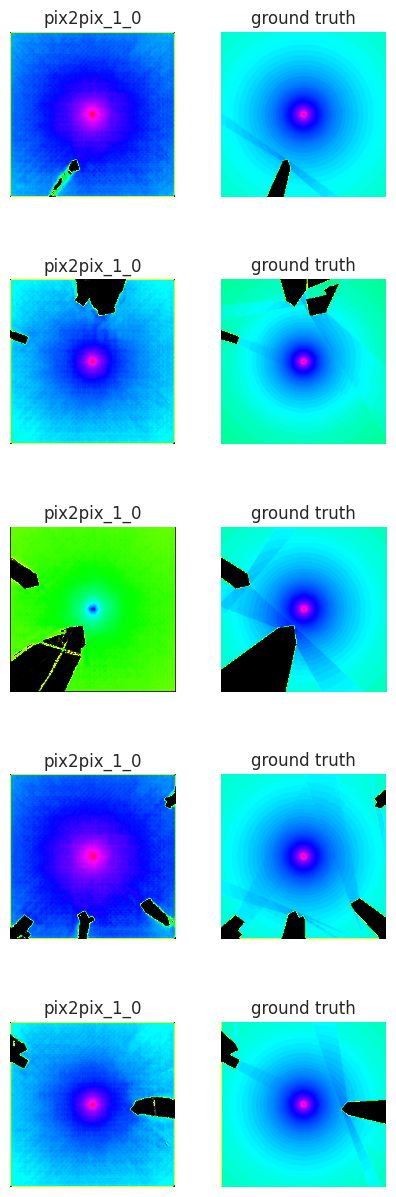

In [22]:
n_samples = 5

example_images_model_1, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                         f"../../data/eval/{model_1}/real",
                                                         n_samples)

pred_model_1 = example_images_model_1[:n_samples]
real = example_images_model_1[n_samples:] 

fig, ax = plt.subplots(nrows=n_samples, ncols=2, figsize=(5, 15))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}")

for idx, cur_path in enumerate(real):
    plot(ax[idx][1], path=cur_path, title=f"ground truth")

plt.subplots_adjust(hspace=0.5)

plt.show();

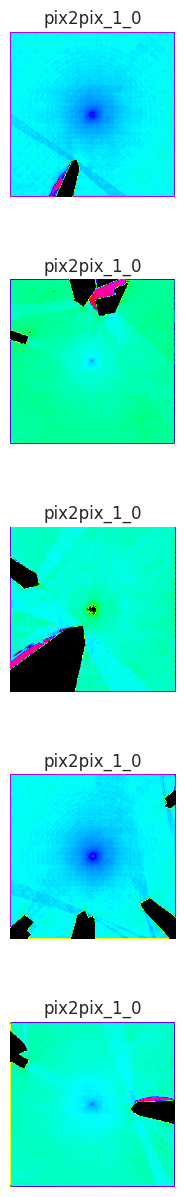

In [24]:
fig, ax = plt.subplots(nrows=n_samples, ncols=1, figsize=(3, 15))

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx], path=cur_path, title=f"{model_1}", sub_image=real[idx], invert=False, scale=True)

plt.subplots_adjust(hspace=0.5)
plt.show();

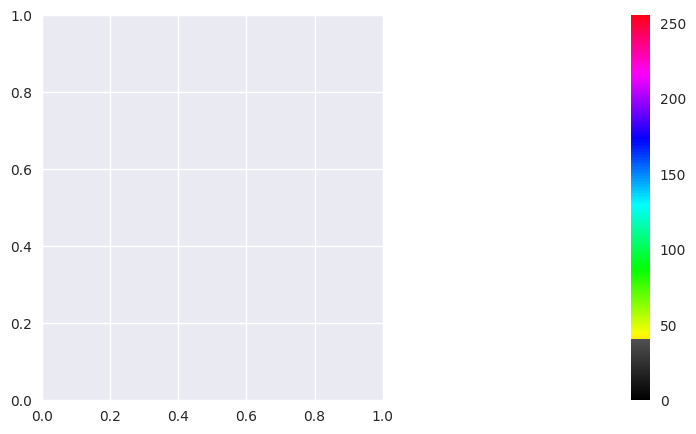

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

# Create a mappable object (for the colorbar)
norm = plt.Normalize(vmin=0, vmax=255)
sm = plt.cm.ScalarMappable(cmap="unique_hsv", norm=norm)
sm.set_array([])  # Required to set the color range without linking it to any image

fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.4)

plt.show()

### Old Code /Visualization

Examples from pix2pix_1_0
Got images with shape: (10, 256, 256, 3)
Transformed shape to: (10, 256, 256, 3)
Invert images...
Using 'seaborn-v0_8' plotting style.
Making you a beautiful plot...
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


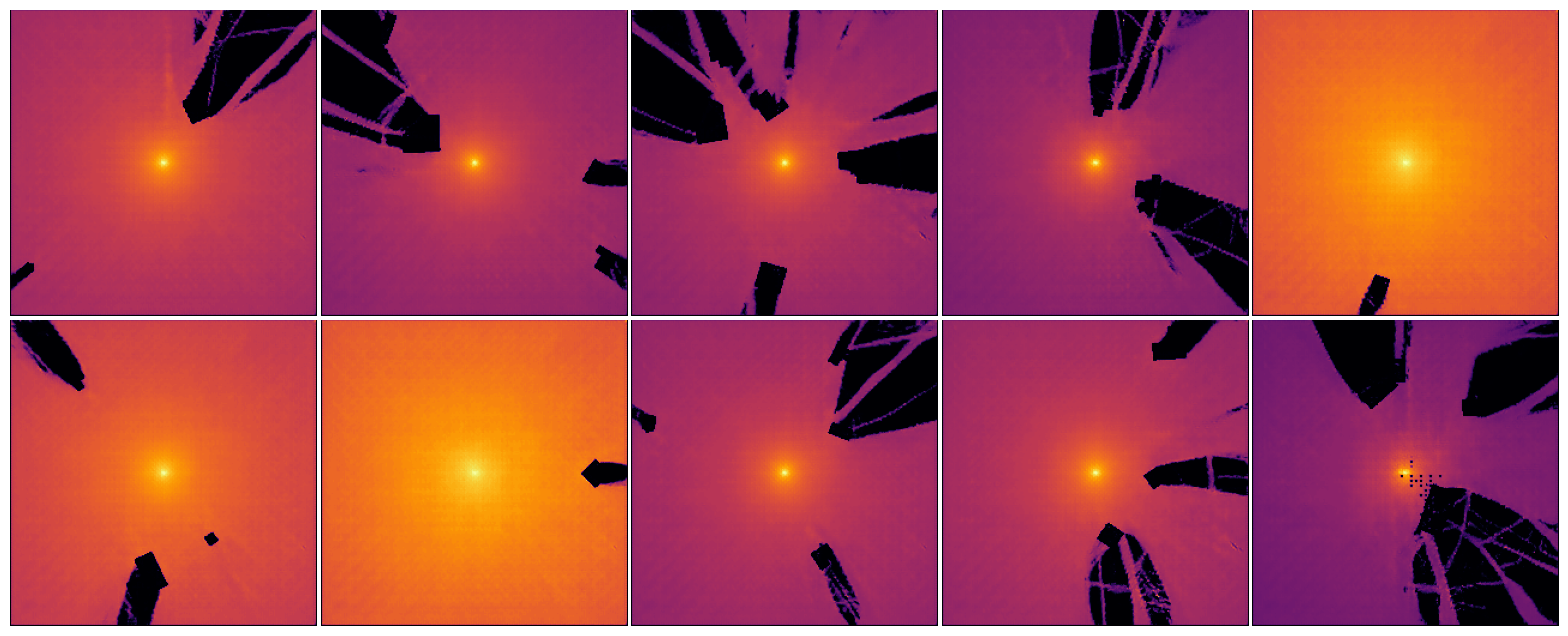

In [26]:
path = f"../../data/eval/{model_1}/pred"
example_images = [os.path.join(path, cur_img) for cur_img in os.listdir(path)]
print(f"Examples from {model_1}")
show_images(image_paths=example_images[:10], image_width=4, cols=5, cmap="inferno", color_space="grey", invert=True);